In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os, sys, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, recall_score
from pandas.api.types import CategoricalDtype

import mxnet as mx
from mxnet import gluon, autograd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.data.build_feather_data import cat_cols, id_cols, target

In [5]:
plt.rcParams['figure.figsize'] = (8,8)
pd.set_option('display.max_columns', 500)

In [6]:
def plot_losses(losses, labels):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('BCE')
    plt.title('Evolution of training and testing losses')
    hs = list()
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    for i, loss_set in enumerate(losses):
        train_1,  test_1  = list(zip(*loss_set))
        label = labels[i]
        color = colors[i+1 % len(colors)]
        x = range(len(train_1))
        h1,  = plt.plot(x, train_1, '{c}'.format(c=color), marker='o', ms=3, label='%s train loss' % label)
        h2,  = plt.plot(x, test_1, '{c}--'.format(c=color), marker='o', ms=3, label='%s dev loss' % label)
        hs += [h1, h2]
    
    l   = plt.legend(handles=hs)
    _ = plt.grid()

# Data Processing
## Load Raw

In [7]:
df_train = pd.read_feather('data/train.feather')
df_test = pd.read_feather('data/test.feather')

In [8]:
numeric_cols = [c for c in df_train.columns.tolist() if c not in cat_cols + id_cols + [target]]

In [9]:
df_train[numeric_cols].head()

,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,68.5,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [10]:
log_cols = [
    'TransactionAmt',
    'dist1',
    'dist2',
] + ['C%d' % i for i in range(1,15)]

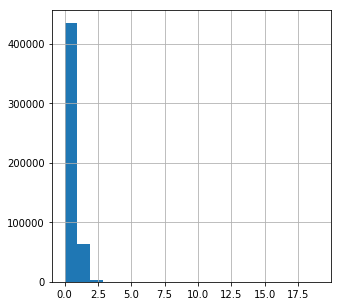

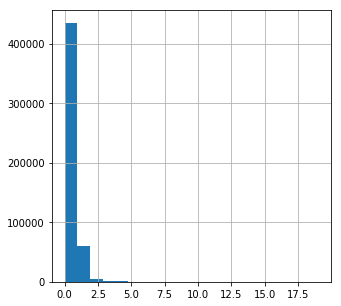

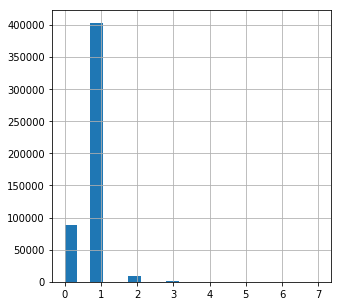

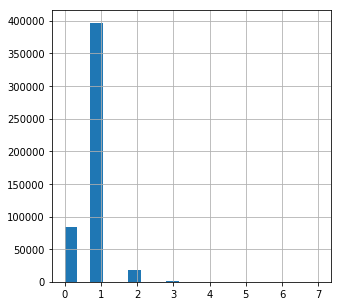

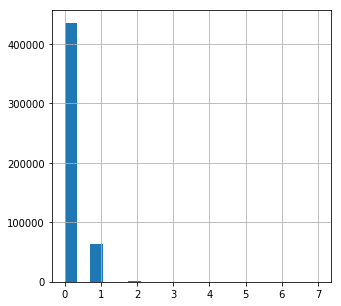

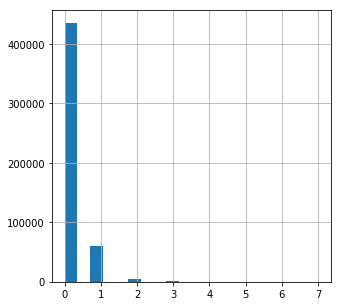

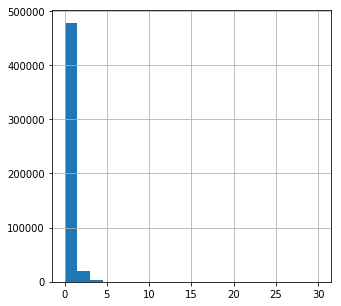

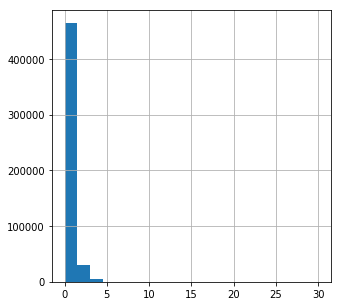

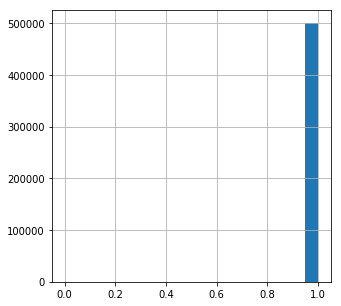

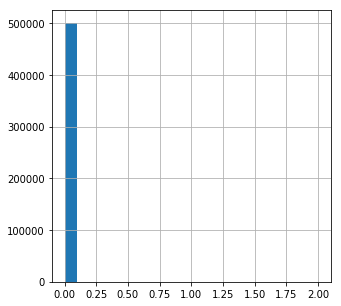

In [11]:
for col in ['V%d' % i for i in range(80,90)]:
    df_train[col].hist(bins=20, figsize=(5,5))
    plt.show()

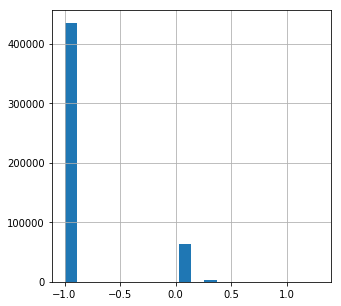

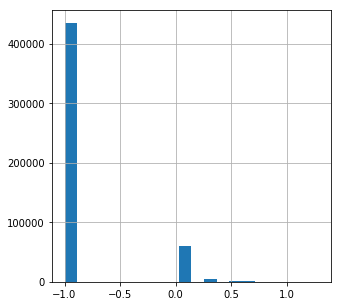

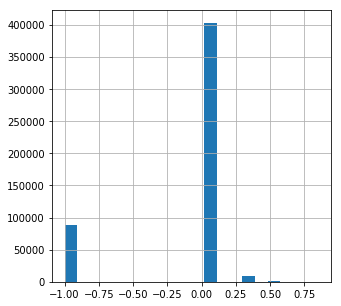

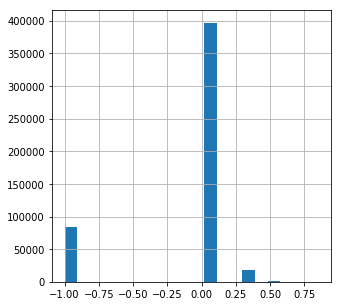

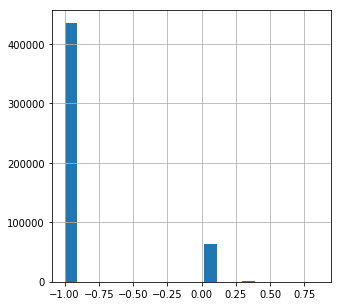

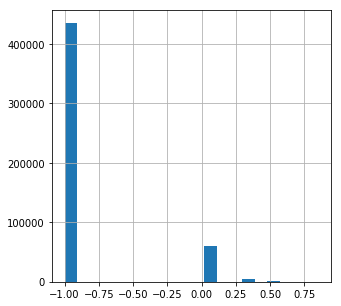

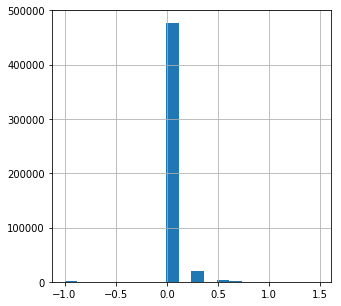

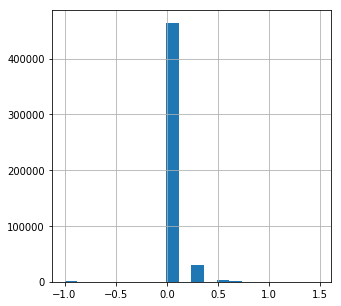

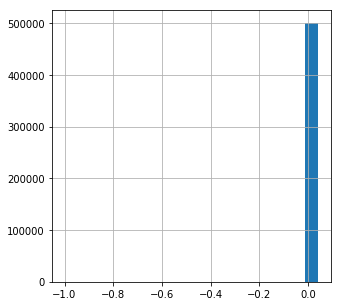

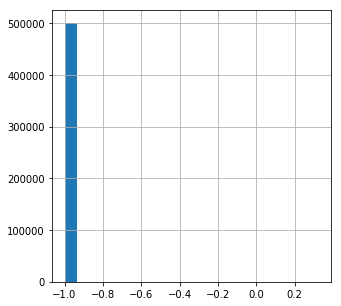

In [12]:
for col in ['V%d' % i for i in range(80,90)]:
    df_train[col].apply(lambda x: np.log10(x+1e-1)).hist(bins=20, figsize=(5,5))
    plt.show()

## Log transform

In [13]:
for c in log_cols:
    df_train[c] = df_train[c].apply(lambda x: np.log10(x+1e-1))
    df_test[c] = df_test[c].apply(lambda x: np.log10(x+1e-1))

## Standardize Numeric

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
def standardize_numeric(df_train, df_test, cols):
    ss = StandardScaler()
    df_train[cols] = ss.fit_transform(df_train[cols])
    df_test[cols] = ss.transform(df_test[cols])
    return df_train, df_test

In [16]:
non_log_cols = [c for c in numeric_cols if c not in log_cols]

In [17]:
df_train, df_test = standardize_numeric(df_train, df_test, non_log_cols+log_cols)

## FillNA

In [18]:
df_train[non_log_cols+log_cols] = df_train[non_log_cols+log_cols].fillna(0)
df_test[non_log_cols+log_cols] = df_test[non_log_cols+log_cols].fillna(0)

In [19]:
df_train[log_cols+non_log_cols].head()

,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,-0.144434,0.315159,0.0,-0.605667,-0.609052,-0.063449,-0.512765,-0.667834,-0.236679,-0.329972,-0.519224,0.188563,-0.503527,0.142256,-0.421123,-0.692291,-0.343615,-0.509625,0.000000,-0.245948,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.607738,-0.718232,0.0,0.0,0.0,-0.807712,0.007391,-0.188248,-0.243307,0.348922,0.258476,-0.190849,-0.239092,-0.148892,-0.183482,-0.889542,-0.867054,0.862411,0.753187,0.022356,-0.368033,-0.360108,-0.36778,-0.364112,0.431549,0.331173,-0.382481,-0.368077,-0.140469,-0.19018,0.120595,0.057142,-0.027121,-0.02666,-0.759501,-0.733229,-0.395627,-0.386712,-0.383375,-0.389188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.825721,0.710800,-0.17291,-0.182989,-0.367557,-0.355189,-0.354433,-0.340812,0.389851,0.273742,-0.368017,-0.349187,0.018359,0.087692,0.007643,-0.02246,-0.759595,-0.735662,-0.386048,-0.372866,-0.381321,-0.386873,0.886072,0.766295,-0.163039,-0.184859,-0.360269,-0.351166,-0.3376,-1.998943,-1.873506,-0.378984,-0.35711,-0.15456,-0.194524,0.027468,-0.028222,-0.778573,-0.748332,-0.400132,-0.384805,-0.398417,-0.049349,-0.049831,-0.062054,-0.217494,-0.328731,-0.288757,-0.043204,-0.023024,-0.049806,-0.131696,-0.083328,-0.09015,0.020503,-0.056854,-0.115962,-0.07955,-0.036191,-0.063292,-0.045261,-0.084391,-0.170446,-0.115069,-0.011107,-0.035942,-0.020019,-0.020973,-0.063733,-0.036159,-0.136412,-0.248527,-0.180028,-0.055382,-0.051812,-0.067800,-0.077034,-0.291701,-0.193181,-0.045679,-0.023151,-0.052641,-0.058704,-0.085924,-0.075689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [20]:
df_train[log_cols].describe()

,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05,5.905400e+05
mean,2.306118e-15,-6.101771e-17,2.166678e-17,-2.224973e-16,-1.388954e-16,6.730123e-15,-3.677005e-16,-2.841978e-17,-1.343984e-16,-4.211230e-17,2.722139e-16,-5.698395e-17,-7.001711e-16,1.611698e-17,4.650160e-16,-3.006818e-17,6.957553e-18
std,1.000001e+00,6.351985e-01,2.524210e-01,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.684497e+00,-2.019487e+00,-2.153822e+00,-2.702104e+00,-2.690117e+00,-6.344943e-02,-5.127650e-01,-6.678341e-01,-2.062185e+00,-3.299719e-01,-5.192245e-01,-1.260386e+00,-5.035272e-01,-2.739853e+00,-4.211232e-01,-2.001527e+00,-2.237971e+00
25%,-6.247411e-01,0.000000e+00,0.000000e+00,-6.056666e-01,-6.090525e-01,-6.344943e-02,-5.127650e-01,-6.678341e-01,-2.366792e-01,-3.299719e-01,-5.192245e-01,-1.260386e+00,-5.035272e-01,-4.698763e-01,-4.211232e-01,-6.922908e-01,-3.436155e-01
50%,-1.403243e-01,0.000000e+00,0.000000e+00,-6.056666e-01,-6.090525e-01,-6.344943e-02,-5.127650e-01,-6.678341e-01,-2.366792e-01,-3.299719e-01,-5.192245e-01,1.885630e-01,-5.035272e-01,-4.698763e-01,-4.211232e-01,-1.265911e-01,-3.436155e-01
75%,4.865458e-01,0.000000e+00,0.000000e+00,3.001701e-01,2.901420e-01,-6.344943e-02,-5.127650e-01,6.622055e-01,2.555950e-01,-3.299719e-01,-5.192245e-01,5.792930e-01,-5.035272e-01,1.422558e-01,-4.211232e-01,6.169450e-01,1.672250e-01
max,6.307180e+00,3.110570e+00,2.287010e+00,6.700563e+00,6.812418e+00,3.398046e+01,7.588322e+00,3.857129e+00,5.568008e+00,1.003917e+01,7.399901e+00,3.362294e+00,7.431336e+00,7.076725e+00,8.770335e+00,3.611984e+00,5.320337e+00


## Encode categories

In [21]:
def fill_na(df_train, df_test, cat_cols):
    df_train.loc[:,cat_cols] = df_train[cat_cols].fillna('<UNK>')
    df_test.loc[:,cat_cols] = df_test[cat_cols].fillna('<UNK>')

    return df_train, df_test

def overwrite_rare(df_train, df_test, cat_cols, count_threshold=100):
    for col in cat_cols:
        val_counts = df_train[col].value_counts()
        good_cats = val_counts[val_counts>=count_threshold].index.values
        df_train.loc[~df_train[col].isin(good_cats), col] = '<RARE>'
        df_test.loc[~df_test[col].isin(good_cats), col] = '<RARE>'

def cat_to_int(df_train, df_test, col):
    catDtype = CategoricalDtype(categories=df_train[col].value_counts().index.values)
    return (df_train[col].astype(catDtype).cat.codes.values+1,
            df_test[col].astype(catDtype).cat.codes.values+1)

In [22]:
df_train, df_test = fill_na(df_train, df_test, cat_cols)

In [23]:
overwrite_rare(df_train, df_test, cat_cols)

In [24]:
df_train[cat_cols].head()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,W,<RARE>,<UNK>,150.0,discover,142.0,credit,315.0,87.0,<UNK>,<UNK>,T,T,T,M2,F,T,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>
1,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,<UNK>,<UNK>,<UNK>,<UNK>,M0,T,T,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>
2,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,<UNK>,T,T,T,M0,F,F,F,F,F,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>
3,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,<UNK>,<UNK>,<UNK>,<UNK>,M0,T,F,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>
4,H,<RARE>,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,mobile,<RARE>,NotFound,<UNK>,-480.0,New,NotFound,166.0,<UNK>,542.0,144.0,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [25]:
cat_cols_encoded = list()
for col in cat_cols:
    df_train[col+'_code'], df_test[col+'_code'] = cat_to_int(df_train, df_test, col)
    cat_cols_encoded.append(col+'_code')

In [26]:
N_val = int(df_train.shape[0]*0.05)
df_val = df_train.sort_values(by='TransactionDT').tail(N_val)
df_train_sample = df_train[~df_train.index.isin(df_val.index)]

In [27]:
df_train.shape[0], df_train_sample.shape[0], df_val.shape[0], df_test.shape[0]

(590540, 561013, 29527, 506691)

In [28]:
df_train_sample.TransactionID.isin(df_val.TransactionID.unique()).sum()

0

In [29]:
train_dataset = gluon.data.ArrayDataset(
    df_train_sample[cat_cols_encoded+non_log_cols+log_cols].values.tolist(),
    df_train_sample[target].values.astype('float32'))

val_dataset = gluon.data.ArrayDataset(
    df_val[cat_cols_encoded+non_log_cols+log_cols].values.tolist(),
    df_val[target].values.astype('float32'))

test_dataset = gluon.data.ArrayDataset(
    df_test[cat_cols_encoded+non_log_cols+log_cols].values.tolist())

In [30]:
bs = 512
ctx = [mx.gpu(7)]

In [31]:
train_data = gluon.data.DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=0,
)

val_data = gluon.data.DataLoader(
    dataset=val_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=0,
)

test_data = gluon.data.DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=0,
)

In [32]:
for x, y in train_data:
    break

In [33]:
x


[[ 2.00000000e+00  1.49000000e+02  2.60000000e+01 ...  1.70430137e+00
  -6.92290797e-01 -3.43615484e-01]
 [ 3.00000000e+00  1.00000000e+00  2.00000000e+01 ... -4.21123228e-01
  -6.92290797e-01 -3.43615484e-01]
 [ 4.00000000e+00  3.90000000e+01  1.00000000e+01 ... -4.21123228e-01
  -2.00152657e+00 -2.23797141e+00]
 ...
 [ 1.00000000e+00  2.00000000e+00  7.00000000e+00 ... -4.21123228e-01
  -6.92290797e-01 -3.43615484e-01]
 [ 2.00000000e+00  1.17000000e+02  5.40000000e+01 ...  1.70430137e+00
  -6.92290797e-01 -3.43615484e-01]
 [ 2.00000000e+00  1.00000000e+00  3.25000000e+02 ...  1.70430137e+00
  -1.26591104e-01 -3.43615484e-01]]
<NDArray 512x431 @cpu(0)>

In [34]:
def calculate_recall_at_fpr(y_true, y_hat, fpr_target=0.04):
        fpr, tpr, thresholds = roc_curve(y_true, y_hat)
        fpr_idx = max(np.where(fpr<=fpr_target)[0])
        thresh = thresholds[fpr_idx]

        return recall_score(y_true, y_hat>thresh)


def evaluate_network(network, data_iterator, ctx):
    loss_acc = 0.
    loss = gluon.loss.SigmoidBCELoss()

    y_trues = list()
    y_hats = list()

    for idx, (X, y) in enumerate(data_iterator):
        X_ = gluon.utils.split_and_load(X, ctx)
        y_ = gluon.utils.split_and_load(y, ctx)

        preds = [network(x) for x in X_]
        losses = [loss(p, y).asnumpy() for p, y in zip(preds, y_)]
        
        loss_acc += sum(losses).mean() / len(ctx) 

        y_trues += [y_i.asnumpy() for y_i in y_]
        y_hats += [p.asnumpy().flatten() for p in preds]

    y_true = np.concatenate(y_trues)
    y_hat = np.concatenate(y_hats)

    auc = roc_auc_score(y_true, y_hat)
    recall = calculate_recall_at_fpr(y_true, y_hat)

    return loss_acc / float(idx + 1), auc, recall


def train(network, train_data, holdout_data, epochs, ctx, pos_weight=None,
          lr=1e-3, wd=1e-5, optimizer='adam', trainer_fp='./models/example.trainer'):

        np.random.seed(123)
        mx.random.seed(123)

        trainer = gluon.Trainer(network.collect_params(), optimizer,
                                {'learning_rate': lr, 'wd': wd})

        if os.path.exists(trainer_fp):
            trainer.load_states(trainer_fp)

        loss = gluon.loss.SigmoidBCELoss()

        network.hybridize()

        losses_output = []

        dev_loss, auc, recall = evaluate_network(network, holdout_data, ctx)

        print("Baseline: Dev AUC {:.4f}, Recall@0.04 FPR {:.4f}".format(auc, recall))

        for e in range(epochs):
            loss_acc = 0.
            for idx, (X, y) in enumerate(train_data):
                X_ = gluon.utils.split_and_load(X, ctx)
                y_ = gluon.utils.split_and_load(y, ctx)

                with autograd.record():
                    preds = [network(x) for x in X_]
                    if pos_weight:
                        losses = [loss(p, y, mx.nd.ones_like(y)*pos_weight) for p, y in zip(preds, y_)]
                    else:
                        losses = [loss(p, y) for p, y in zip(preds, y_)]

                [l.backward() for l in losses]

                loss_acc += sum([l.asnumpy().mean() for l in losses]) / len(ctx)
                trainer.step(X.shape[0])

            dev_loss, auc, recall = evaluate_network(network, holdout_data, ctx)
            train_loss = loss_acc / float(idx + 1)

            print(
                "Epoch [{}], Training BCE {:.4f}, Dev AUC {:.4f}, Dev Recall@0.04 FPR {:.4f}".format(
                    e + 1, train_loss, auc, recall)
            )
            losses_output.append((train_loss, dev_loss))

        trainer.save_states(trainer_fp)
        return losses_output

In [35]:
max_idx_map = (df_train[cat_cols_encoded].max()+1).to_dict()

In [36]:
embed_dim_map = {k: (v, int(v**0.25)) for k,v in max_idx_map.items()}

In [37]:
class RawTransactionEmbed(gluon.nn.HybridBlock):
    def __init__(self, cat_cols, embed_dim_map, numeric_cols, dropout=0.0):
        super(RawTransactionEmbed, self).__init__(prefix='RawTransactionEmbed_')

        self.dropout_ = dropout
        self.embeddings = list()
        
        with self.name_scope():
            for col in cat_cols:
                in_dim, out_dim = embed_dim_map[col]
                embedding = gluon.nn.Embedding(
                    input_dim=in_dim,
                    output_dim=out_dim,
                    prefix='%s_embed_' % col,
                )
                self.embeddings.append(embedding)
                self.register_child(embedding)

            if self.dropout_:
                self.dropout = gluon.nn.Dropout(self.dropout_, prefix='dropout_')


    def hybrid_forward(self, F, X):
        embeds = list()
        for i, embedding in enumerate(self.embeddings):            
            embeds.append(embedding(F.slice_axis(X, axis=1, begin=i, end=i+1)))
        
        net = F.flatten(F.concat(*embeds, dim=2))
        # Concat the embedding with numeric
        net = F.concat(
            net, 
            F.cast(F.slice_axis(X, axis=1, begin=49, end=None), 'float32')
        )
        
        if self.dropout_:
            net = self.dropout(net)

        return net

In [38]:
net_raw = gluon.nn.HybridSequential()
net_raw.add(RawTransactionEmbed(cat_cols_encoded, embed_dim_map, non_log_cols+log_cols, dropout=0.5))
net_raw.add(gluon.nn.Dense(64))
net_raw.add(gluon.nn.Activation('relu'))
net_raw.add(gluon.nn.Dense(1))
#net_raw = RawTransactionEmbed(cat_cols_encoded, embed_dim_map, non_log_cols+log_cols, dropout=0.5)

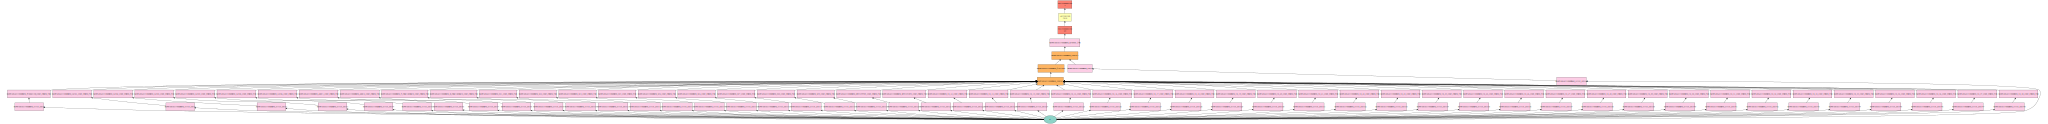

In [82]:
mx.viz.plot_network(net_raw(mx.sym.var('X')), node_attrs={"fixedsize":"false"})

In [39]:
rm ./models/nn/raw/v4_numeric.trainer

rm: cannot remove ‘./models/nn/raw/v4_numeric.trainer’: No such file or directory


In [40]:
net_raw.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)

In [41]:
N_fraud = df_train_sample[target].sum()
N_legit = df_train_sample.shape[0] - N_fraud

In [42]:
pos_weight = N_legit*0.2 / float(N_fraud)

In [43]:
train_raw_parms = {
    'wd': 1e-5,
    'trainer_fp': './models/nn/raw/v4_numeric.trainer',
    'ctx': ctx,
    'lr': 1e-3,
    'pos_weight': pos_weight
}

In [44]:
losses_output = train(net_raw, train_data, val_data, 1, **train_raw_parms)

Baseline: Dev AUC 0.4061, Recall@0.04 FPR 0.0582
Epoch [1], Training BCE 0.6313, Dev AUC 0.8913, Dev Recall@0.04 FPR 0.5851


In [87]:
losses_output += train(net_raw, train_data, val_data, 10, **train_raw_parms)

Baseline: Dev AUC 0.9187, Recall@0.04 FPR 0.6527
Epoch [1], Training BCE 0.4524, Dev AUC 0.9179, Dev Recall@0.04 FPR 0.6527
Epoch [2], Training BCE 0.4534, Dev AUC 0.9206, Dev Recall@0.04 FPR 0.6561
Epoch [3], Training BCE 0.4512, Dev AUC 0.9185, Dev Recall@0.04 FPR 0.6561
Epoch [4], Training BCE 0.4525, Dev AUC 0.9186, Dev Recall@0.04 FPR 0.6493
Epoch [5], Training BCE 0.4473, Dev AUC 0.9169, Dev Recall@0.04 FPR 0.6518
Epoch [6], Training BCE 0.4494, Dev AUC 0.9194, Dev Recall@0.04 FPR 0.6578
Epoch [7], Training BCE 0.4507, Dev AUC 0.9182, Dev Recall@0.04 FPR 0.6433
Epoch [8], Training BCE 0.4505, Dev AUC 0.9179, Dev Recall@0.04 FPR 0.6459
Epoch [9], Training BCE 0.4497, Dev AUC 0.9181, Dev Recall@0.04 FPR 0.6553
Epoch [10], Training BCE 0.4501, Dev AUC 0.9192, Dev Recall@0.04 FPR 0.6493


In [88]:
net_raw.export('./models/nn/raw/v4_numeric', epoch=len(losses_output))

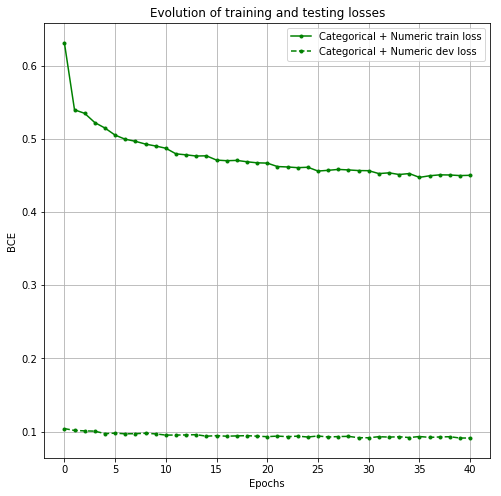

In [89]:
plot_losses([losses_output], ['Categorical + Numeric'])

# Viz
## Transaction Embeddings

In [47]:
from sklearn.manifold import TSNE

In [48]:
val_embeds = list()
for x, y in val_data:
    val_embeds.append(net_raw[0](x.as_in_context(ctx[0])).asnumpy())
    
val_embeds = np.vstack(val_embeds)

In [49]:
val_embeds.shape

(29527, 451)

In [325]:
tsne_raw = TSNE(perplexity=25, n_iter=2000,)

In [326]:
val_tsne = tsne_raw.fit_transform(val_embeds)

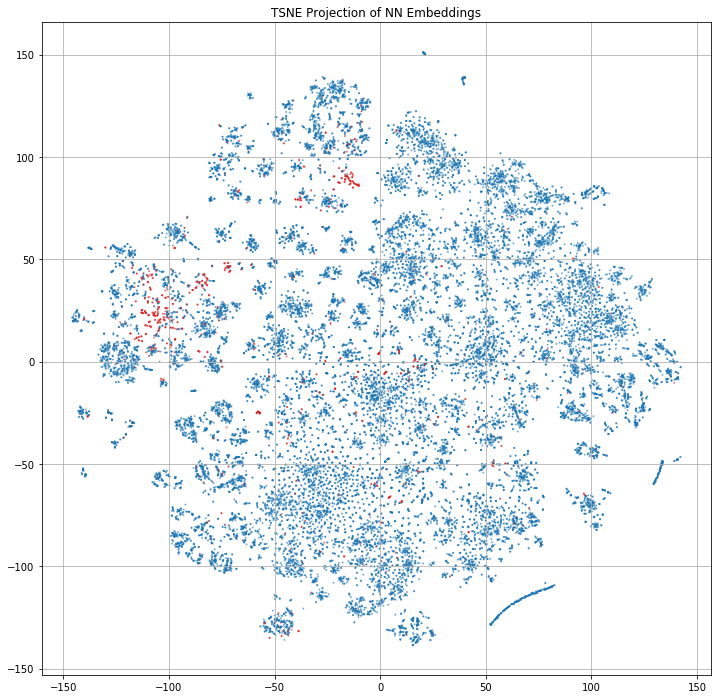

In [74]:
fig, ax = plt.subplots(figsize=(12,12))
colors = ['tab:red' if y else 'tab:blue' for y in df_val[target].values]
ax.scatter(x=val_tsne[:,0], y=val_tsne[:,1], c=colors, s=1, alpha=0.5)
ax.grid()

_ = ax.set_title('TSNE Projection of NN Embeddings')

In [75]:
idx = np.where((val_tsne[:,0]<100)&(val_tsne[:,0]>50)&(val_tsne[:,1]<-125)&(val_tsne[:,1]>-150))[0]

In [76]:
idx.shape

(40,)

In [77]:
df_val.iloc[idx].sort_values(by='card1').head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ProductCD_code,card1_code,card2_code,card3_code,card4_code,card5_code,card6_code,addr1_code,addr2_code,P_emaildomain_code,R_emaildomain_code,M1_code,M2_code,M3_code,M4_code,M5_code,M6_code,M7_code,M8_code,M9_code,DeviceType_code,DeviceInfo_code,id_12_code,id_13_code,id_14_code,id_15_code,id_16_code,id_17_code,id_18_code,id_19_code,id_20_code,id_21_code,id_22_code,id_23_code,id_24_code,id_25_code,id_26_code,id_27_code,id_28_code,id_29_code,id_30_code,id_31_code,id_32_code,id_33_code,id_34_code,id_35_code,id_36_code,id_37_code,id_38_code
561611,3548611,0,14864408,0.313545,S,15775,481.0,150.0,mastercard,102.0,credit,330.0,87.0,0.0,0.0,<UNK>,yahoo.com,0.735421,0.290142,-0.063449,2.262852,-0.667834,-2.062185,-0.329972,2.822564,-1.260386,2.118718,0.982225,-0.421123,1.501076,0.868201,-0.325685,-0.713774,-0.454332,0.0,0.0,1.296001,-0.417467,-0.513750,-1.639091,0.706502,0.0,0.0,0.134569,0.000000,0.0,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.096328,-1.125861,0.022356,-0.368033,-0.360108,2.376034,2.325774,-1.918564,-1.845342,2.566855,2.414226,-0.140469,-0.19018,0.120595,0.057142,-0.027121,-0.02666,-0.759501,-0.733229,2.415,2.328633,-0.383375,-0.389188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.129046,-1.159638,-0.17291,-0.182989,-0.367557,-0.355189,2.282065,2.050222,-1.900489,-1.793216,2.446806,2.112916,0.018359,0.087692,0.007643,-0.02246,-0.759595,-0.735662,2.358921,2.196431,-0.381321,-0.386873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.837910,32.579834,33.078231,-0.217494,9.588443,9.213183,40.185040,33.627212,33.977015,16.824851,22.738618,19.080958,0.020503,-0.056854,-0.115962,-0.07955,-0.036191,-0.063292,-0.045261,-0.084391,-0.170446,-0.115069,-0.011107,-0.035942,-0.020019,-0.020973,-0.063733,-0.036159,-0.136412,7.770655,3.390932,38.52

## Device Embeddings

In [50]:
from collections import defaultdict

In [51]:
embed_dim_map

{'ProductCD_code': (6, 1),
 'card1_code': (721, 5),
 'card2_code': (366, 4),
 'card3_code': (26, 2),
 'card4_code': (6, 1),
 'card5_code': (40, 2),
 'card6_code': (5, 1),
 'addr1_code': (64, 2),
 'addr2_code': (6, 1),
 'P_emaildomain_code': (54, 2),
 'R_emaildomain_code': (34, 2),
 'M1_code': (4, 1),
 'M2_code': (4, 1),
 'M3_code': (4, 1),
 'M4_code': (5, 1),
 'M5_code': (4, 1),
 'M6_code': (4, 1),
 'M7_code': (4, 1),
 'M8_code': (4, 1),
 'M9_code': (4, 1),
 'DeviceType_code': (4, 1),
 'DeviceInfo_code': (66, 2),
 'id_12_code': (4, 1),
 'id_13_code': (24, 2),
 'id_14_code': (13, 1),
 'id_15_code': (5, 1),
 'id_16_code': (4, 1),
 'id_17_code': (14, 1),
 'id_18_code': (9, 1),
 'id_19_code': (74, 2),
 'id_20_code': (81, 3),
 'id_21_code': (8, 1),
 'id_22_code': (5, 1),
 'id_23_code': (5, 1),
 'id_24_code': (6, 1),
 'id_25_code': (7, 1),
 'id_26_code': (15, 1),
 'id_27_code': (4, 1),
 'id_28_code': (4, 1),
 'id_29_code': (4, 1),
 'id_30_code': (53, 2),
 'id_31_code': (61, 2),
 'id_32_code'

In [669]:
low_card_cols = [c for c, tup in embed_dim_map.items() if tup[1] < 3]

In [673]:
for col in low_card_cols:
    print(df_train.groupby(col)[target].describe())

                   count      mean       std  min  25%  50%  75%  max
ProductCD_code                                                       
1               439670.0  0.020399  0.141362  0.0  0.0  0.0  0.0  1.0
2                68519.0  0.116873  0.321271  0.0  0.0  0.0  0.0  1.0
3                37699.0  0.037826  0.190778  0.0  0.0  0.0  0.0  1.0
4                33024.0  0.047662  0.213054  0.0  0.0  0.0  0.0  1.0
5                11628.0  0.058996  0.235626  0.0  0.0  0.0  0.0  1.0
               count      mean       std  min  25%  50%  75%  max
card4_code                                                       
1           384767.0  0.034756  0.183162  0.0  0.0  0.0  0.0  1.0
2           189217.0  0.034331  0.182078  0.0  0.0  0.0  0.0  1.0
3             8328.0  0.028698  0.166967  0.0  0.0  0.0  0.0  1.0
4             6651.0  0.077282  0.267058  0.0  0.0  0.0  0.0  1.0
5             1577.0  0.025999  0.159182  0.0  0.0  0.0  0.0  1.0
               count      mean       std  min  2

                       count      mean       std  min  25%  50%  75%  max
R_emaildomain_code                                                       
1                   453249.0  0.020819  0.142777  0.0  0.0  0.0  0.0  1.0
2                    57147.0  0.119184  0.324008  0.0  0.0  0.0  0.0  1.0
3                    27509.0  0.077793  0.267850  0.0  0.0  0.0  0.0  1.0
4                    20529.0  0.029130  0.168174  0.0  0.0  0.0  0.0  1.0
5                    11842.0  0.051512  0.221048  0.0  0.0  0.0  0.0  1.0
6                     3701.0  0.034855  0.183438  0.0  0.0  0.0  0.0  1.0
7                     2507.0  0.165138  0.371379  0.0  0.0  0.0  0.0  1.0
8                     1812.0  0.011589  0.107058  0.0  0.0  0.0  0.0  1.0
9                     1508.0  0.010610  0.102491  0.0  0.0  0.0  0.0  1.0
10                    1398.0  0.128755  0.335049  0.0  0.0  0.0  0.0  1.0
11                     852.0  0.001174  0.034259  0.0  0.0  0.0  0.0  1.0
12                     762.0  0.049869

               count      mean       std  min   25%  50%  75%  max
id_13_code                                                        
1           463220.0  0.021750  0.145866  0.0  0.00  0.0  0.0  1.0
2            58099.0  0.074752  0.262993  0.0  0.00  0.0  0.0  1.0
3            26365.0  0.066793  0.249668  0.0  0.00  0.0  0.0  1.0
4            14429.0  0.103334  0.304405  0.0  0.00  0.0  0.0  1.0
5            10048.0  0.116640  0.321007  0.0  0.00  0.0  0.0  1.0
6             3666.0  0.134206  0.340920  0.0  0.00  0.0  0.0  1.0
7             2878.0  0.073662  0.261266  0.0  0.00  0.0  0.0  1.0
8             2499.0  0.023609  0.151859  0.0  0.00  0.0  0.0  1.0
9             1468.0  0.033379  0.179685  0.0  0.00  0.0  0.0  1.0
10            1147.0  0.184830  0.388329  0.0  0.00  0.0  0.0  1.0
11            1066.0  0.062852  0.242810  0.0  0.00  0.0  0.0  1.0
12             842.0  0.288599  0.453380  0.0  0.00  0.0  1.0  1.0
13             813.0  0.050431  0.218966  0.0  0.00  0.0  0.0 

               count      mean       std  min  25%  50%  75%  max
id_28_code                                                       
1           449562.0  0.021009  0.143415  0.0  0.0  0.0  0.0  1.0
2            76232.0  0.102752  0.303637  0.0  0.0  0.0  0.0  1.0
3            64746.0  0.052281  0.222595  0.0  0.0  0.0  0.0  1.0
               count      mean       std  min  25%  50%  75%  max
id_29_code                                                       
1           449562.0  0.021009  0.143415  0.0  0.0  0.0  0.0  1.0
2            74926.0  0.104463  0.305862  0.0  0.0  0.0  0.0  1.0
3            66052.0  0.051338  0.220689  0.0  0.0  0.0  0.0  1.0
               count      mean       std  min  25%  50%  75%  max
id_30_code                                                       
1           512975.0  0.033571  0.180122  0.0  0.0  0.0  0.0  1.0
2            21155.0  0.031056  0.173475  0.0  0.0  0.0  0.0  1.0
3            13110.0  0.032952  0.178518  0.0  0.0  0.0  0.0  1.0
4         

In [52]:
col_of_interest = 'card1'
embed_idx = cat_cols.index(col_of_interest)

In [53]:
embeds = net_raw[0].embeddings[embed_idx].weight.data().asnumpy()

In [54]:
embeds.shape

(721, 5)

In [55]:
# Map category codes back to original category values
idx2category = defaultdict(
    lambda: 'OOV', 
    df_train_sample[[col_of_interest, col_of_interest+'_code']].drop_duplicates().set_index(col_of_interest+'_code')[col_of_interest].to_dict(),
)

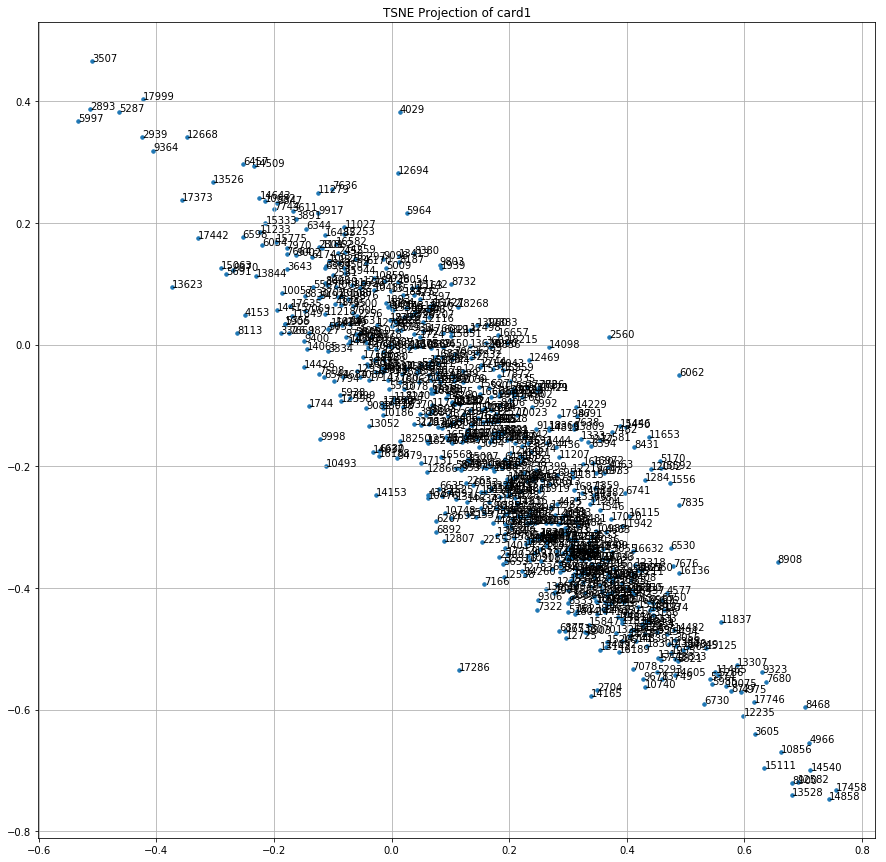

In [56]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x=embeds[:,0], y=embeds[:,1], s=12, alpha=1.)
for i in range(embeds.shape[0]):
    try:
        txt = idx2category[i]
    except KeyError:
        txt = "???"
        continue
        
    ax.annotate(txt, (embeds[i,0], embeds[i,1]), fontsize=10)

ax.grid()

_ = ax.set_title('TSNE Projection of %s' % col_of_interest)

In [652]:
cat_value = '296.0'
df_train_sample[df_train_sample[col_of_interest]==cat_value][target].describe()

count    342.000000
mean       0.225146
std        0.418291
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: isFraud, dtype: float64

In [666]:
tsne_embeds = TSNE(perplexity=15, n_iter=3000,)

In [667]:
embeds_tsne = tsne_raw.fit_transform(embeds)

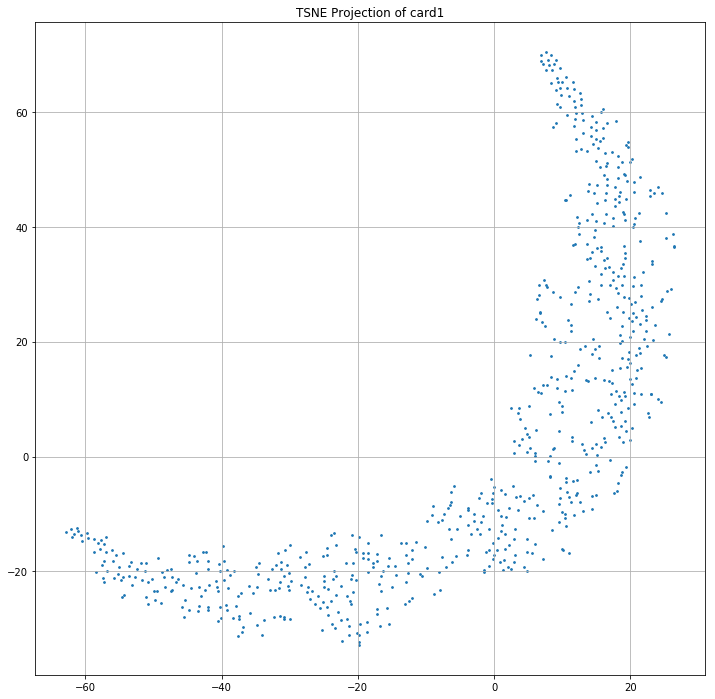

In [78]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(x=embeds_tsne[:,0], y=embeds_tsne[:,1], s=3, alpha=1.)
for i in range(embeds_tsne.shape[0]):
    try:
        txt = idx2category[i]
    except KeyError:
        txt = "???"
        continue
        
    #ax.annotate(txt, (embeds_tsne[i,0], embeds_tsne[i,1]), fontsize=8)

ax.grid()

_ = ax.set_title('TSNE Projection of %s' % col_of_interest)

## Score on test

In [454]:
y_test_hat = list()
for x in test_data:
    y_test_hat.append(net_raw(x.as_in_context(ctx[0])).sigmoid().asnumpy())
    
y_test_hat = np.concatenate(y_test_hat)

In [455]:
y_test_hat.shape

(506691, 1)

In [456]:
df_test.shape

(506691, 482)

### Compare with existing submission as sanity check

In [457]:
df_prev_sub = pd.read_csv('data/submissions/submission_big_ensemble_v2.csv')

In [458]:
df_prev_sub.head()

,TransactionID,isFraud
0,3663549,0.004175
1,3663550,0.018855
2,3663551,0.002972
3,3663552,0.009278
4,3663553,0.025987


In [459]:
df_prev_sub['new_pred'] = y_test_hat

In [460]:
df_prev_sub.head()

,TransactionID,isFraud,new_pred
0,3663549,0.004175,0.001157
1,3663550,0.018855,0.008045
2,3663551,0.002972,0.000494
3,3663552,0.009278,0.000147
4,3663553,0.025987,0.002650


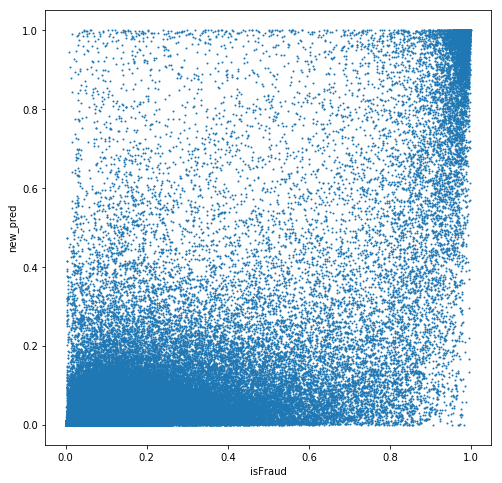

In [461]:
fig, ax = plt.subplots()
_ = df_prev_sub.plot.scatter(x='isFraud', y='new_pred', ax=ax, s=1)

In [462]:
nn_weight = 0.2
y_test_ensemble = df_prev_sub.isFraud*(1-nn_weight)+df_prev_sub.new_pred*nn_weight

In [463]:
df_test_new = df_prev_sub.copy()
#df_test_new['isFraud'] = y_test_hat
df_test_new['isFraud'] = y_test_ensemble

In [464]:
df_test_new.head()

,TransactionID,isFraud,new_pred
0,3663549,0.003571,0.001157
1,3663550,0.016693,0.008045
2,3663551,0.002477,0.000494
3,3663552,0.007452,0.000147
4,3663553,0.021319,0.002650


In [465]:
df_test_new[['TransactionID', 'isFraud']].to_csv('data/submissions/nn_ensemble_v3.csv', index=False)

In [466]:
!kaggle competitions submit -c ieee-fraud-detection -f data/submissions/nn_ensemble_v3.csv -m "NN ensembled with Trees.  Weighted pos class."

100%|██████████████████████████████████████| 13.8M/13.8M [00:00<00:00, 15.6MB/s]
Successfully submitted to IEEE-CIS Fraud Detection